[<< Previous: Model Fitting](03_rating_pred.ipynb)

# Results analysis

In this notebook, we will conduct some high-level analysis of our model's prediction behavior. We will again use the `R` language and `tidyverse` tools for this analysis.

First, let's import the libraries that will be required for this notebook.

In [1]:
library(tidyverse)
library(yaml)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Configurations

Before we do our analysis, let's make sure we are retrieving the prediction outputs for the appropriate experiment.

In [2]:
config_id <- "mlml6_rate_pred_clsp"
main_config <- yaml.load_file(paste0("../experiments/configs/", config_id, "/main.yaml"))
dataset_id <- main_config$dataset_id
results_base <- paste0("../experiments/results/", config_id)

## Load results

Let's load in the results of our fitted model's test set predictons.

In [3]:
results_df <- read_csv(paste0(results_base, "/predictions_df.csv"))

Rows: 3310 Columns: 2
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (2): y, yhat

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Error metrics

Let's compute some error metrics. Notice that, for our grouped (summary) metrics, we round $y$ to the nearest $0.5$ and then group within that subset. This is an easy way to place observations of a continuous target variable into meaningful groups. In our dataset, the ratings are mentally rounded to the nearest $0.1$ already (no reviewers would give an album a $7.51$), but this is a rather small bin size and would be difficult to look at in a figure.

In [4]:
# What is the bin size we want to have for our groupings of y?
rnd_unit = 0.25

# Observation-level error metrics
error_df <- results_df %>%
    mutate(
        y_rnd = round(y / rnd_unit) * rnd_unit,
        se = (y - yhat)^2,
        resid = y - yhat
    )

# y bin-level error metrics
error_summary_df <- error_df %>%
    group_by(y_rnd) %>%
    summarize(
        mse = mean(se),
        rmse = sqrt(mse),
        resid_mean = mean(resid),
        resid_sd = sd(resid),
        n_obs = n()
    )

The first thing we should look at is the top-line RMSE and average (absolute) residual values that our model obtained on the test data.

In [5]:
error_df %>%
    summarize(
        rmse = sqrt( mean(se) ),
        resid_mean = mean( abs(resid) )
    )

rmse,resid_mean
<dbl>,<dbl>
0.8956093,0.6577236


At first glance, this is not too bad. Let's do a deeper investigation into the bias in our model's predictions on the test set.

## Bias

We observed in our exploratory analysis that the ratings tended to tightly cluster in a certain range. This means that our model will likely perform much better for the "common" range of ratings, and worse the further outside of this range an observation is. Furthermore, it's likely that the estimates $\hat{y}$ will tend to be "pulled" towards the mean value of $y$. That is, $\hat{y}$ for $y \ll \bar{y}$ will tend to be *overestimates* while $\hat{y}$ for $\bar{y} \ll y$ will tend to be *underestimates*.

First, let's do some setup for our visualizations.

In [6]:
set_theme_elements <- function(plt) {
    plt +
        theme_classic() +
        theme(text = element_text(size=16))
}

step_size <- 10
size_breaks1 <- c(-Inf, seq(10, 500, by = step_size), Inf)
size_labels1 <- c("<10", sapply(seq(10, 490, by = step_size), function(x) paste0(x, "-", x + step_size)), ">500")
size_values1 <- seq_along(size_labels1)
sign_colors <- c("neg" = "firebrick1", "pos" = "steelblue")

In [7]:
# Settings for plots
options(repr.plot.width = 16, repr.plot.height = 12, repr.plot.res = 100)

### Visualizing residuals

Let's visualize the residuals of each of our predictions. Notice the three horizontal lines. These denote (in units of rating "points") residuals of $-1$, $0$, and $1$. There is also a slope $1$ line, with a y-axis intercept at $\bar{y}$.

Remember that *negative* residuals indicate *overestimation* and *positive* residuals indicate *underestimation*.

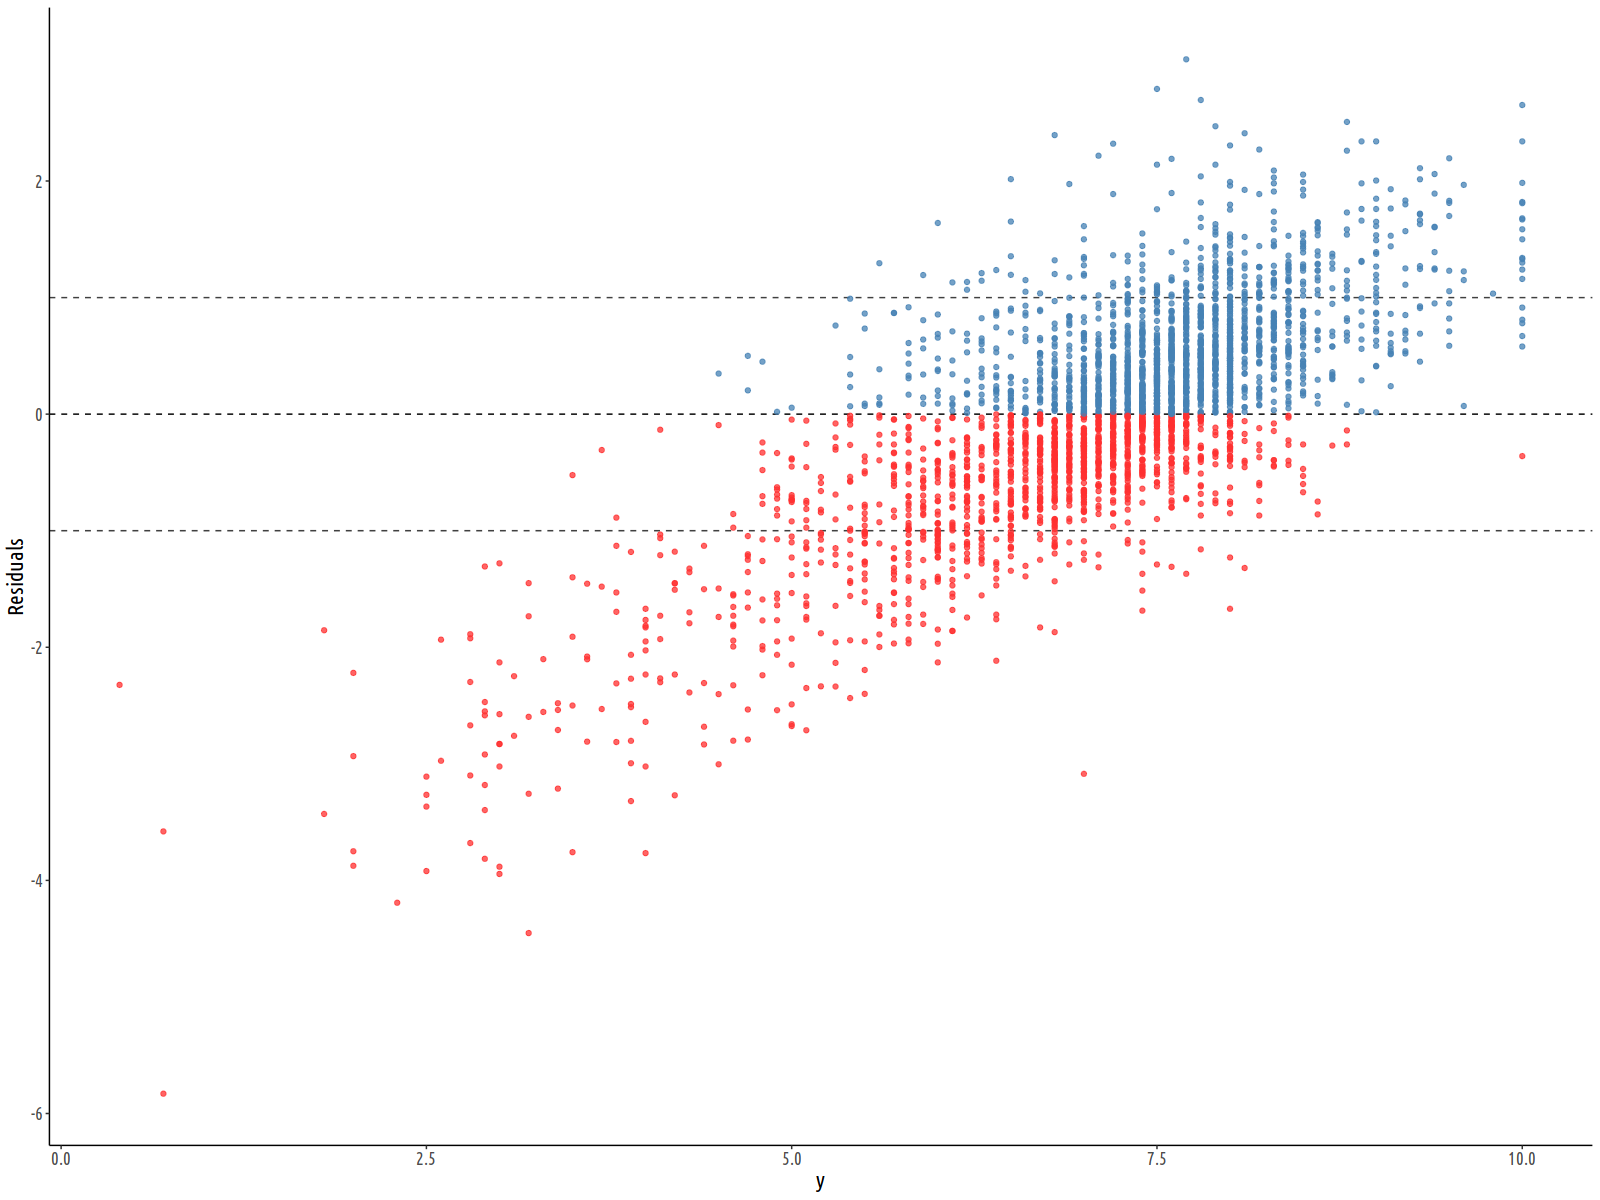

In [8]:
plt <- error_df %>%
    mutate(
        sign = as_factor(ifelse(resid > 0, "pos", "neg")),
    ) %>%
    ggplot() +
    geom_hline(aes(yintercept = 0.0), linetype = "dashed", color = "gray0") +
    geom_hline(aes(yintercept = -1.0), linetype = "dashed", color = "gray25") +
    geom_hline(aes(yintercept = 1.0), linetype = "dashed", color = "gray25") +
    geom_abline(slope = 1, intercept = results_df %>% pull(y) %>% mean(), color="firebrick") +
    geom_point(aes(x = y, y = resid, color = sign), alpha = 0.75) +
    scale_color_manual(values = sign_colors)

plt <- plt %>%
    set_theme_elements() +
    guides(color = "none") +
    xlab("y") +
    ylab("Residuals")

plt

This is a lot to take in. While it appears that there are (very) large residuals when $y$ is small, this is much less bad the closer we get to the more common values of $y$. However, the points tend to overlap where there is a high density of observations, so the actual amount of density is difficult to judge visually. Let's try a different approach where we can get a better sense of the overall behavior.

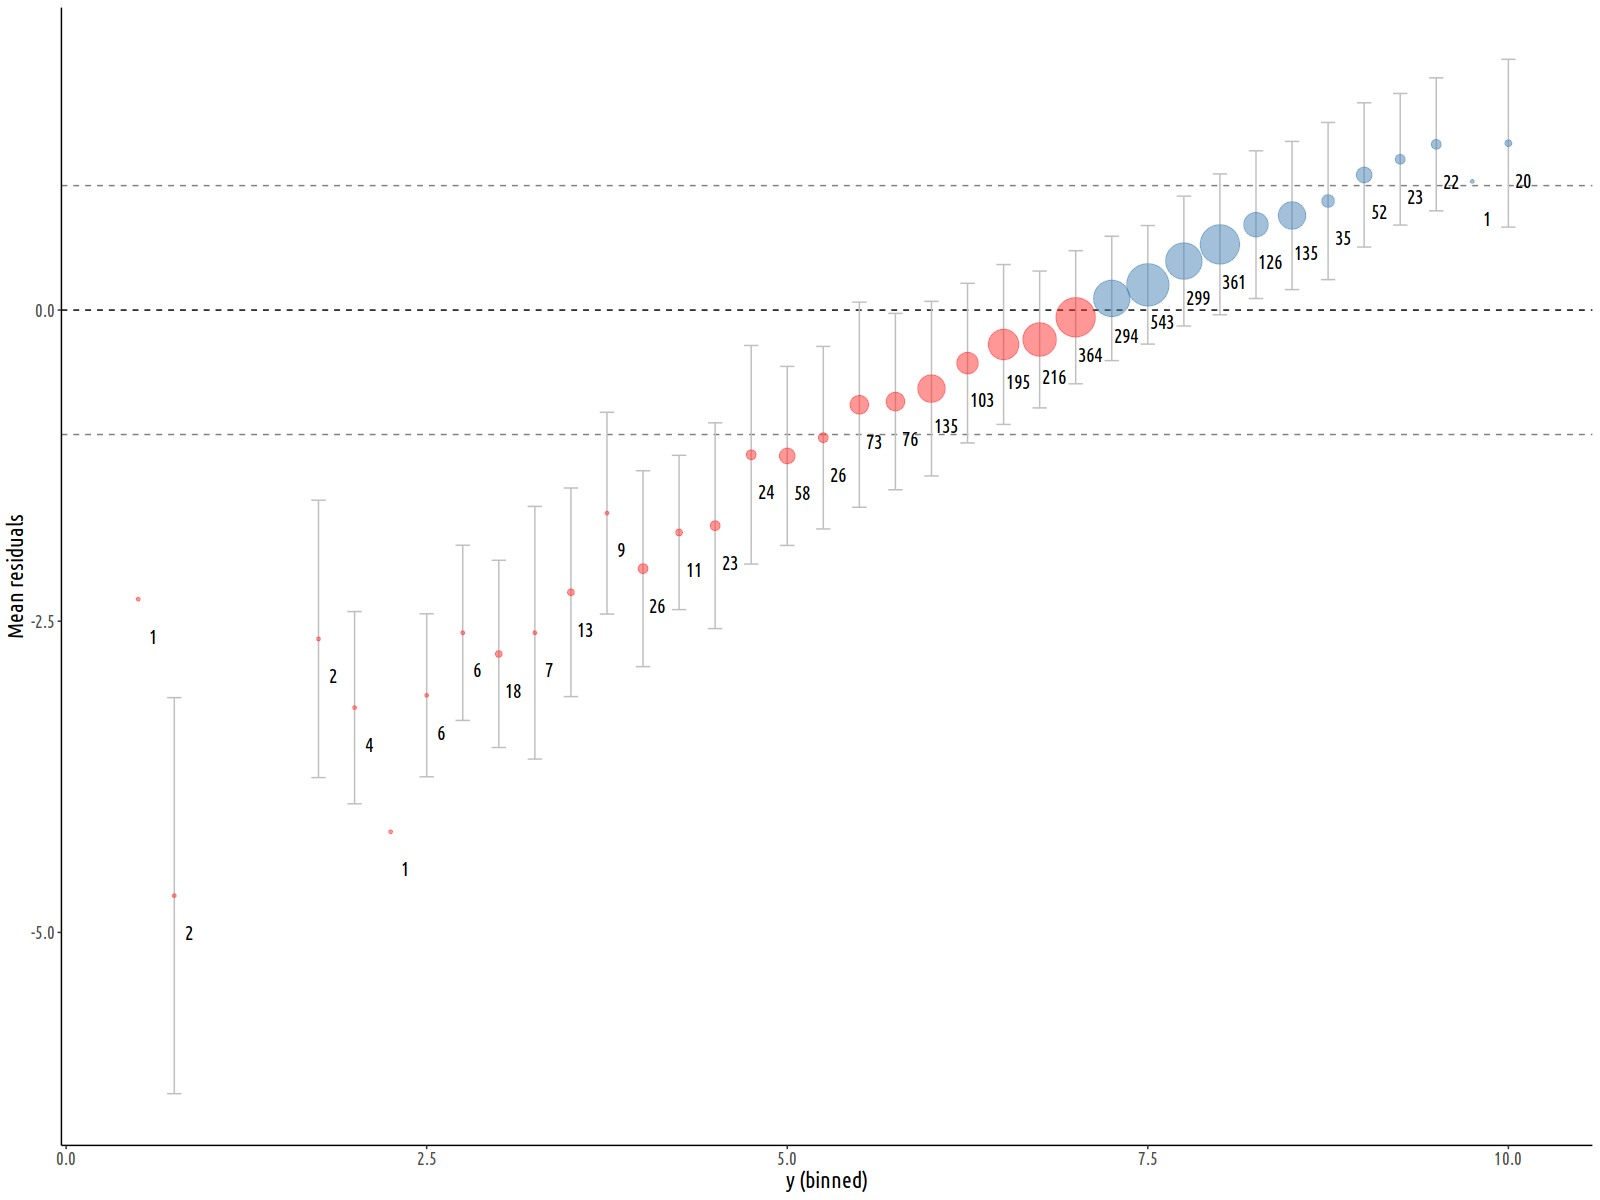

In [9]:
plt <- error_summary_df %>%
    mutate(
        sign = as_factor(ifelse(resid_mean > 0, "pos", "neg")),
        n_obs_f = cut(
            n_obs,
            breaks = size_breaks1, 
            labels = size_labels1
        )
    ) %>%
    ggplot() +
    geom_hline(aes(yintercept = 0.0), linetype = "dashed", color = "gray0") +
    geom_hline(aes(yintercept = -1.0), linetype = "dashed", color = "gray50") +
    geom_hline(aes(yintercept = 1.0), linetype = "dashed", color = "gray50") +
    geom_abline(slope = 1, intercept = results_df %>% pull(y) %>% mean(), color="firebrick") +
    geom_errorbar(aes(x = y_rnd, ymin = resid_mean - resid_sd, ymax = resid_mean + resid_sd), width = 0.1, color = "gray75") +
    geom_point(aes(x = y_rnd, y = resid_mean, size = n_obs_f, color = sign), alpha = 0.5) +
    geom_text(aes(x = y_rnd, y = resid_mean, label = as.character(n_obs)), nudge_y = -0.3, nudge_x = 0.1, size=5) +
    scale_size_manual(values = size_values1) +
    scale_color_manual(values = sign_colors)

plt <- plt %>%
    set_theme_elements() +
    guides(size = "none", color = "none") +
    xlab("y (binned)") +
    ylab("Mean residuals")

plt

Here, we have plotted the mean residuals versus the binned $y$ (rounded to the nearest $0.25$) along with the standard deviation of residuals within those bins. The points (mean residual values) are explicitly labeled with, and sized proportionally to, the number of observations in the given bin.

To make things more concrete, let's look at some numbers. Here, we check to see what percentage of observations in the test set fall within +/- $1$, and +/- $2$ rating "points".

In [10]:
n_row <- error_df %>% nrow()

n_row_within_1 <- error_df %>%
    filter(abs(resid) <= 1.0) %>%
    nrow()

n_row_within_2 <- error_df %>%
    filter(abs(resid) <= 2.0) %>%
    nrow()
pct_within_1 <- round((n_row_within_1 / n_row) * 100, 2)
pct_withinn_2 <- round((n_row_within_2 / n_row) * 100, 2)
print(pct_within_1)
print(pct_withinn_2)

[1] 79.06
[1] 96.22


All-in-all, it's not too bad. Almost $80\%$ of observations were guessed within $1$ rating points of their true value, while over $95\%$ were guessed within $2$ rating points of their true value.

## Baseline

Our previous analysis showed that our model was mostly successful, at least for observations with ratings that weren't too far from the mean. However, how does this compare to a simpler model? Let's use a very simple baseline predictor: $\hat{y}_i = \bar{y}_{\text{train}}$ for all $i$ in the test set. In other words, predict the mean $y$ value of the training set for each $x_i$ in the test set.

Let's take a look at the performance of this simple baseline.

### Load training data

First we need to load in the training data.

In [11]:
train_df <- read_csv(paste0("../data/pitchfork/", dataset_id, "/summary_df.csv"))

Rows: 22063 Columns: 8
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (6): artist, album, reviewer, genre, label, reviewed
dbl (2): rating, review_n_tokens

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Naive model

Next, we define our naive model $\hat{f}(x_i) = \hat{y}_i = \bar{y}_{\text{train}}$ .

In [12]:
yhat_baseline <- train_df %>% pull(rating) %>% mean()
yhat_baseline

[1] 7.112646

### Comparison

Now, we can compare our sophisticated NLP model to our baseline (naive) model.

Let's compute error metrics for our naive model.

In [13]:
# Observation-level error metrics
baseline_error_df <- results_df %>%
    mutate(yhat = yhat_baseline) %>%
    mutate(
        y_rnd = round(y / rnd_unit) * rnd_unit,
        se = (y - yhat)^2,
        resid = y - yhat
    )

Now, we compare our baseline's performance with the NLP model. Notice that we do not replicate the residuals plots - this is simply because the residuals for the baseline would fall along the slope $1$ line with intercept at $\bar{y}_{\text{test}}$. In fact, if we look back to the mean residuals plot above, this will give us a hint about how our NLP regression model will compare to the baseline.

In [14]:
baseline_error_df %>%
    summarize(
        rmse = sqrt( mean(se) ),
        resid_mean = mean( abs(resid) )
    )

rmse,resid_mean
<dbl>,<dbl>
1.163958,0.8412766


In [15]:
error_df %>%
    summarize(
        rmse = sqrt( mean(se) ),
        resid_mean = mean( abs(resid) )
    )

rmse,resid_mean
<dbl>,<dbl>
0.8956093,0.6577236


Sure enough, we see that our regression model outperforms the baseline in terms of RMSE and mean residuals. While the difference may not be as stark as we might hope, there is clearly an added benefit of predicting using the NLP model.

## Closing thoughts

While our NLP regression model outperformed the simple $\bar{y}_{\text{train}}$ baseline model, there are steps we could take to improve or further assess our performance. Some of those steps include:

1. Compare our model to a more sophisticated baseline. There are other regression models that are simpler than our NLP regressor, but more powerful than our naive baseline. It could be insightful to fit such a model and perform another comparison.
2. Up-sample extreme observations during training. We see that there are clearly issues with systematic (under/over)estimation for extreme/rare data points. Up-sampling these during training could help reduce bias in our model's predictions.
3. Try an even more sophisticated NLP regression model. We chose a lighter-weight transformer model (`MiniLM-L6`) to save on computational cost. It would be interesting to see if a larger model (e.g., `MPNet`) performed better.
4. Attempt other techniques to address long review texts. Our solution in this project was to simply truncate reviews that exceeded our model's maximum sequence length. We could try a more complicated approach, such as breaking reviews into multiple "sub-reviews" and pooling their embeddings. We could also attempt to use models that were designed to handle longer sequences.

Overall, we built a regressor by fine-tuning a pre-trained transformer model with a regression head, and showed that it outperformed a simple baseline predictor.